In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("pcaMethods")

In [2]:
Output = '/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1015. Fire Sufficient Similarity/P1015.3. Analyses/P1015.3.3. Cluster Analysis/Output'
cur_date = '041525'

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(pcaMethods)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(cowplot)
library(pheatmap)

# reading in file
full_df = data.frame(read_excel("Input/Processed_Data_041125.xlsx")) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setd

In [3]:
head(full_df)
dim(full_df)

,HAWC_ID,Metric,Data,Study,Class,DTXSID,Name,Value
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,993956,Volume,WS,Ihantola et al. 2022,Metal,Sb,Sb,21.74856
2,993956,Volume,WS,Ihantola et al. 2022,Metal,Cr,Cr,77.00000
3,993956,Volume,WS,Ihantola et al. 2022,Metal,Cu,Cu,190.00000
4,993956,Volume,WS,Ihantola et al. 2022,Metal,As,As,1.80000
5,993956,Volume,WS,Ihantola et al. 2022,Metal,Ca,Ca,2800.00000
6,993956,Volume,WS,Ihantola et al. 2022,Metal,Cd,Cd,25.00000


[1] 1398    8

This analysis will use PCA to explore if chemical and metal concentrations of control, WS, and WF samples are similar using PCA.

In [4]:
# will run PCA on each class, so the df will be split
split_df = full_df %>%
    group_by(Metric, Class) %>%
    group_split


metal_vol_df = split_df[[1]]
pah_vol_df = split_df[[2]]
voc_vol_df = split_df[[3]]
metal_weight_df = split_df[[4]]
pah_weight_df = split_df[[5]]

head(metal_vol_df)

HAWC_ID,Metric,Data,Study,Class,DTXSID,Name,Value
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
993956,Volume,WS,Ihantola et al. 2022,Metal,Sb,Sb,21.74856
993956,Volume,WS,Ihantola et al. 2022,Metal,Cr,Cr,77.00000
993956,Volume,WS,Ihantola et al. 2022,Metal,Cu,Cu,190.00000
993956,Volume,WS,Ihantola et al. 2022,Metal,As,As,1.80000
993956,Volume,WS,Ihantola et al. 2022,Metal,Ca,Ca,2800.00000
993956,Volume,WS,Ihantola et al. 2022,Metal,Cd,Cd,25.00000


In [5]:
# casting wide
wider_metal_vol_df = metal_vol_df %>%
    # creating sample ids
    unite("SampleID", c(colnames(metal_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")
wider_pah_vol_df = pah_vol_df %>%
    unite("SampleID", c(colnames(pah_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")
wider_voc_vol_df = voc_vol_df %>%
    unite("SampleID", c(colnames(voc_vol_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    unique() %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

wider_metal_weight_df = metal_weight_df %>%
    unite("SampleID", c(colnames(metal_weight_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")
wider_pah_weight_df = pah_weight_df %>%
    unite("SampleID", c(colnames(pah_weight_df)[c(1,3,5)]), remove = FALSE) %>%
    select(-Name) %>%
    unique() %>%
    pivot_wider(names_from = "DTXSID", values_from = "Value") %>%
    column_to_rownames(var = "SampleID")

head(wider_metal_vol_df)

,HAWC_ID,Metric,Data,Study,Class,Sb,Cr,Cu,As,Ca,⋯,Mn,Mo,Ni,V,Al,Ba,Na,Pb,Sr,Zn
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
993956_WS_Metal,993956,Volume,WS,Ihantola et al. 2022,Metal,21.74856,77.00000,190.0000,1.8000,2800.0000,⋯,280.00000,3.00000,47.00000,0.89000,1200.000,55.00000,490.00,95.00000,20.00000,17000.000
1263480_WS_Metal,1263480,Volume,WS,Burnet et al. 1990,Metal,293.41495,3480.98097,11187.5000,6331.0838,374250.0000,⋯,11708.33333,28.96280,1375.00000,1750.00000,252833.333,339625.00000,1281125.00,7750.00000,6583.33333,578250.000
1263484_WS_Metal,1263484,Volume,WS,Leese et al. 1989,Metal,293.41495,600.00000,4715.9335,5987.5286,61230.0000,⋯,15885.00000,30.58133,4200.00000,1013.85999,64024.695,2490.00000,955690.00,27240.00000,540.00000,114520.000
266987_WS_Metal,266987,Volume,WS,Seagrave 2005,Metal,299.40747,6200.00000,4397.9704,6348.8307,49200.0000,⋯,1800.00000,31.49017,1617.95867,795.47437,15600.000,61950.75783,674014.27,10700.00000,1087.79672,8900.000
USEPA_TRAP_Metal,USEPA,Volume,TRAP,USEPA,Metal,2.13775,3.91325,12.3138,0.1805,691.6327,⋯,2.17625,1.50950,0.73025,22.18488,1038.674,47.38850,361.70,0.00284,19.81396,1152.385
1070627_WF_Metal,1070627,Volume,WF,Siregar et al. 2022,Metal,162.94087,99.23681,178.8837,1.5500,982.6500,⋯,35.55000,16.05000,52.20000,0.40000,1368.447,53.08183,22844.49,73.80854,22.87509,7656.380


# Principal Component Analysis (PCA)

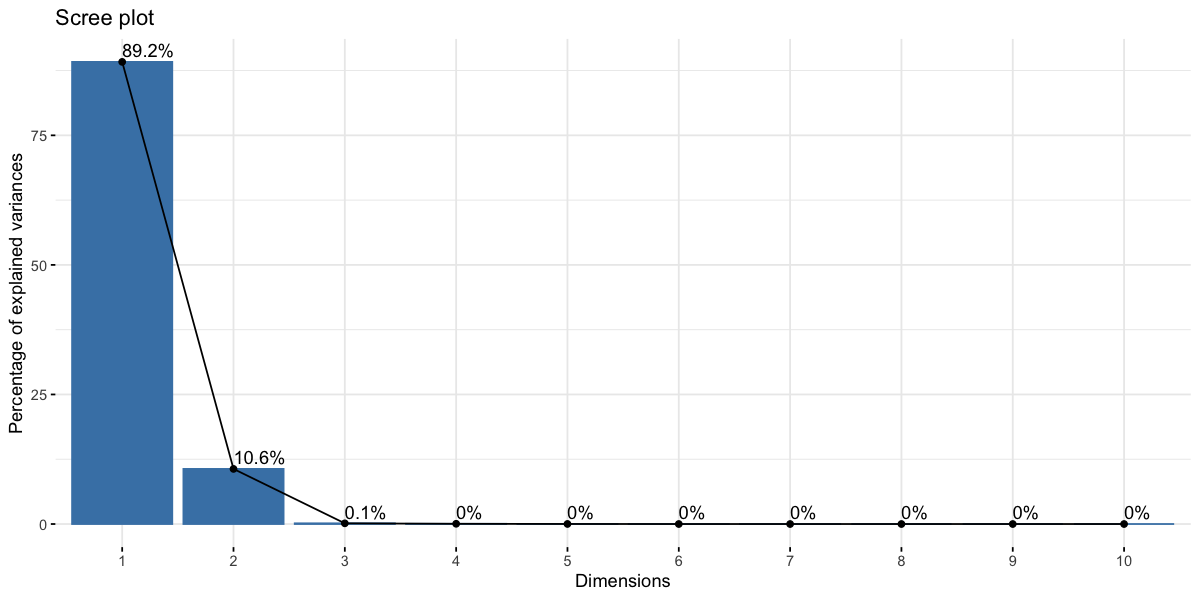

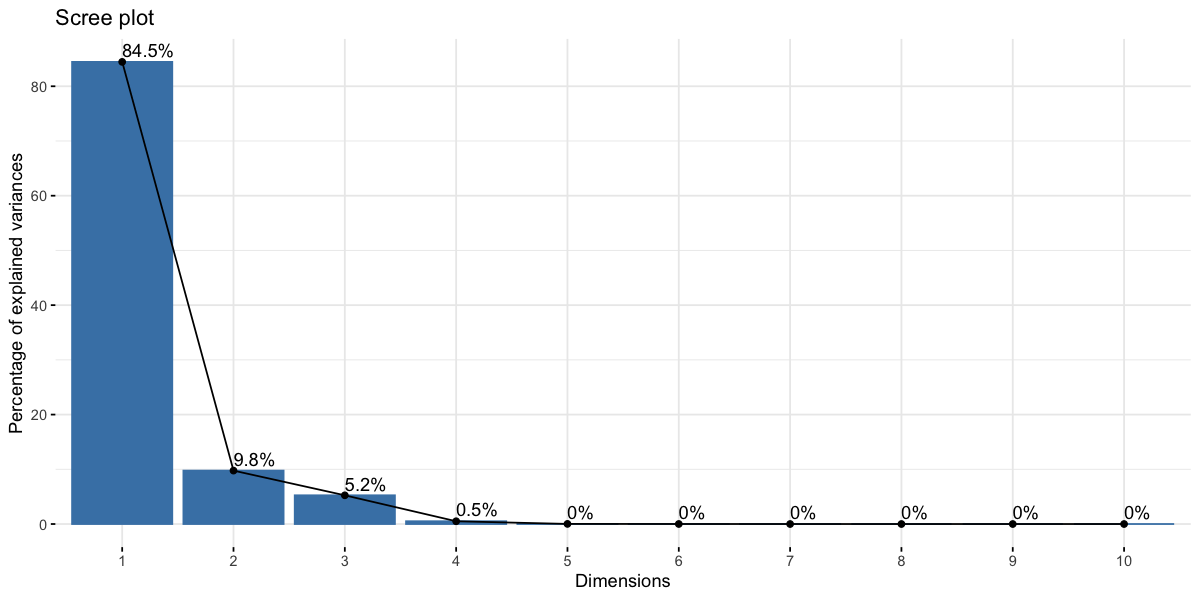

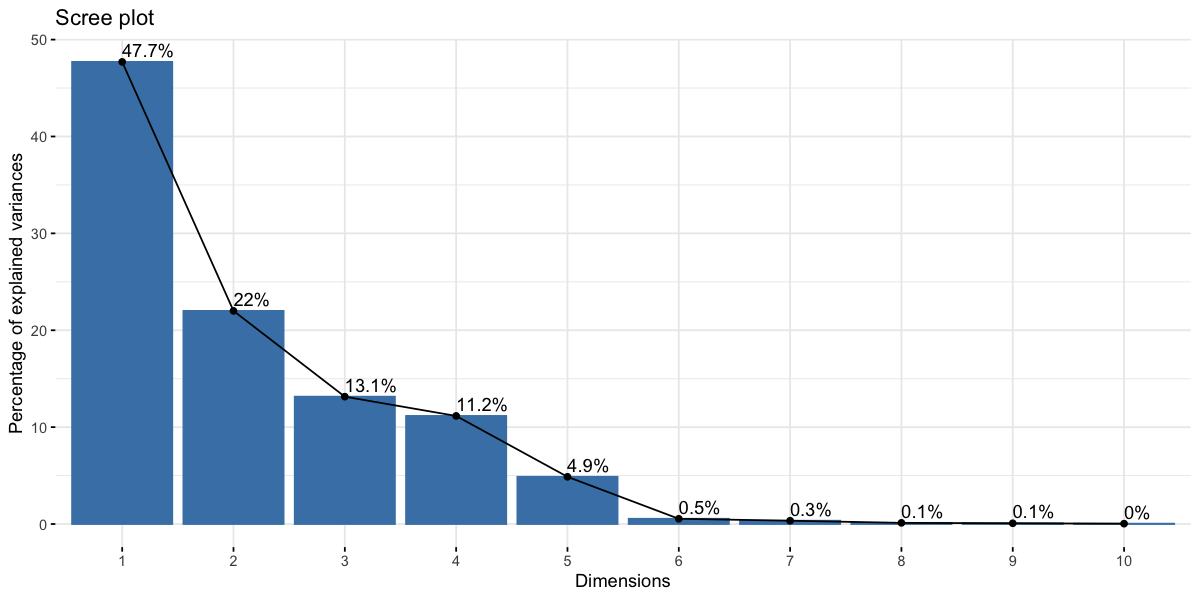

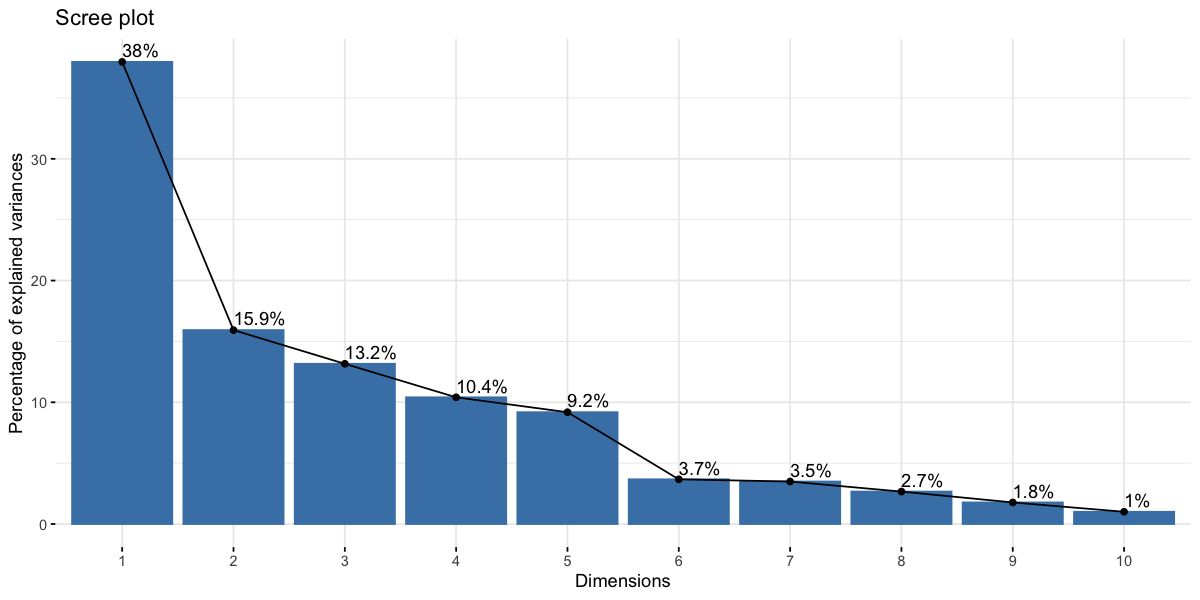

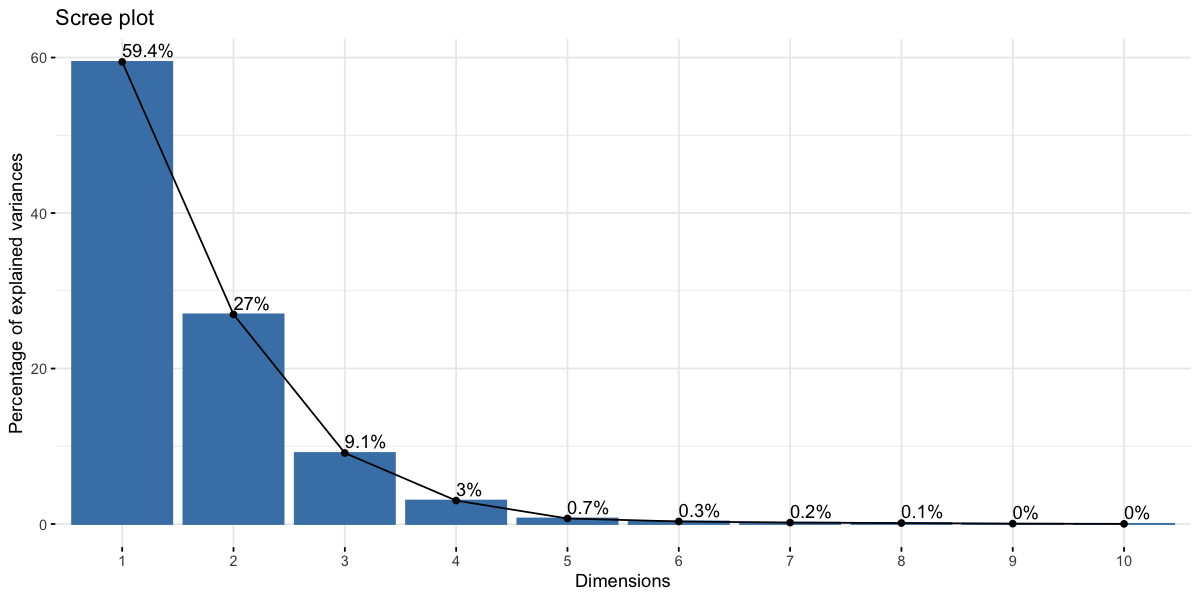

In [6]:
# setting seed for reproducibility
set.seed(12)

# running pca 
metal_vol_pca = prcomp(wider_metal_vol_df[,c(6:ncol(wider_metal_vol_df))], center = TRUE, scale = TRUE)
pah_vol_pca = prcomp(wider_pah_vol_df[,c(6:ncol(wider_pah_vol_df))], center = TRUE, scale = TRUE)
voc_vol_pca = prcomp(wider_voc_vol_df[,c(6:ncol(wider_voc_vol_df))], center = TRUE, scale = TRUE)
metal_weight_pca = prcomp(wider_metal_weight_df[,c(6:ncol(wider_metal_weight_df))], center = TRUE, scale = TRUE)
pah_weight_pca = prcomp(wider_pah_weight_df[,c(6:ncol(wider_pah_weight_df))], center = TRUE, scale = TRUE)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(metal_vol_pca, addlabels = TRUE)
fviz_eig(pah_vol_pca, addlabels = TRUE)
fviz_eig(voc_vol_pca, addlabels = TRUE)
fviz_eig(metal_weight_pca, addlabels = TRUE)
fviz_eig(pah_weight_pca, addlabels = TRUE)

The standard way to detect outliers in genetics is the criterion of being “more than 6 standard deviations away from the mean”. [source](https://privefl.github.io/blog/detecting-outlier-samples-in-pca/)

In [7]:
outlier_detection = function(pca_df){
    # """
    # Creating a scoring function for to detect PCA sample outliers. 
    # :param (input): PCA df (df)
    # :output: outlier names
    # """
    
    # getting scores
    scores = pca_df$x
    # identifying samples that are > 6 standard deviations away from the mean
    outlier_indices = apply(scores, 2, function(x) which( abs(x - mean(x)) > (6 * sd(x)) )) %>%
        Reduce(union, .)
    # getting sample names
    outliers = rownames(scores)[outlier_indices]
    
    return(outliers)
}

# calling fn
metal_vol_outliers = outlier_detection(metal_vol_pca)
pah_vol_outliers = outlier_detection(pah_vol_pca)
voc_vol_outliers = outlier_detection(voc_vol_pca) 
metal_weight_outliers = outlier_detection(metal_weight_pca) 
pah_weight_outliers = outlier_detection(pah_weight_pca)

In [8]:
# getting length
length(metal_vol_outliers)
length(pah_vol_outliers)
length(voc_vol_outliers)
length(metal_weight_outliers)
length(pah_weight_outliers)

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

There were no outliers.

In [9]:
# creating 1 df with eigenvectors, normalized values, condensate, burn condition data??
metal_vol_pca_df = data.frame(metal_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
pah_vol_pca_df = data.frame(pah_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
voc_vol_pca_df = data.frame(voc_vol_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID")
metal_weight_pca_df = data.frame(metal_weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID") 
pah_weight_pca_df = data.frame(pah_weight_pca$x[,1:2]) %>%
               rownames_to_column(var = "SampleID") 

more_data_df = rbind(wider_metal_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_pah_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_voc_vol_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"), 
                         wider_metal_weight_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID"),
                         wider_pah_weight_df[,1:5] %>% 
                                    rownames_to_column(var = "SampleID")) 

full_eigenvector_df = inner_join(rbind(metal_vol_pca_df, pah_vol_pca_df,
                                       voc_vol_pca_df, metal_weight_pca_df, pah_weight_pca_df), 
                                             more_data_df) %>%
    # cleaning variable names here
    mutate(Data = ifelse(Data == "WS", "Woodsmoke",
                                  ifelse(Data == "WF", "Wildfire",
                                      ifelse(Data == "Diesel", "Diesel Exhaust", Data)))) %>%
    separate(SampleID, c(NA, "Sample", NA), sep = "_") %>%
    unite("SampleID", c('HAWC_ID','Sample'), remove = FALSE) %>%
    select(-Sample)


head(full_eigenvector_df)

Joining with `by = join_by(SampleID)`


,SampleID,PC1,PC2,HAWC_ID,Metric,Data,Study,Class
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,993956_WS,1.342979,0.6786669,993956,Volume,Woodsmoke,Ihantola et al. 2022,Metal
2,1263480_WS,1.009716,-0.5183438,1263480,Volume,Woodsmoke,Burnet et al. 1990,Metal
3,1263484_WS,1.039287,-0.4771677,1263484,Volume,Woodsmoke,Leese et al. 1989,Metal
4,266987_WS,1.037272,-0.5311630,266987,Volume,Woodsmoke,Seagrave 2005,Metal
5,USEPA_TRAP,1.349019,0.7058679,USEPA,Volume,TRAP,USEPA,Metal
6,1070627_WF,1.290142,0.4293961,1070627,Volume,Wildfire,Siregar et al. 2022,Metal


In [10]:
# getting the default ggplot colors
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

# calling fn 
cols = gg_color_hue(4)

# getting color palette
palette_colors = brewer.pal(7, "OrRd")

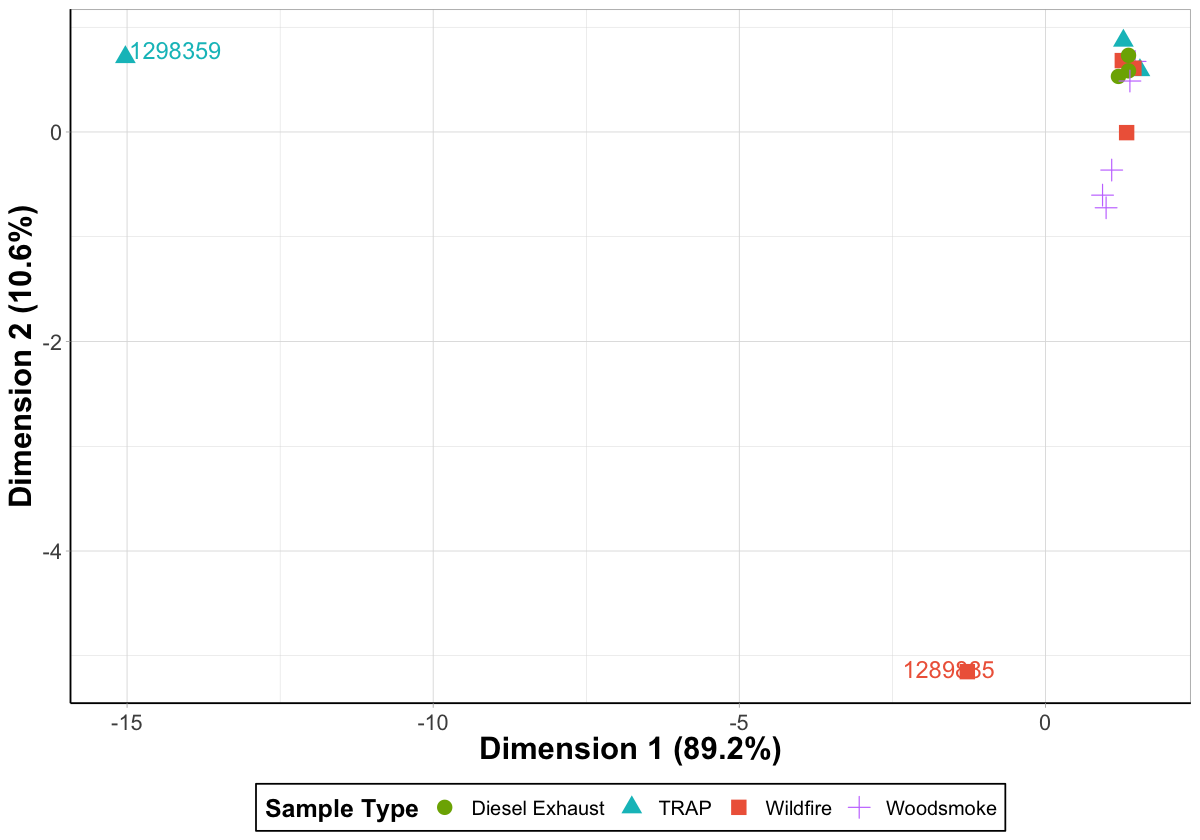

In [11]:
options(repr.plot.width=10, repr.plot.height=7) #changing size
vol1 = ggplot() + 
  geom_point(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'Metal'), aes(x = PC1, y = PC2, color = Data, shape = Data),
             size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'Metal', PC1 < 0), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5, show.legend = FALSE) + 

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (89.2%)', y = 'Dimension 2 (10.6%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2:3], palette_colors[5], cols[4]))

vol1

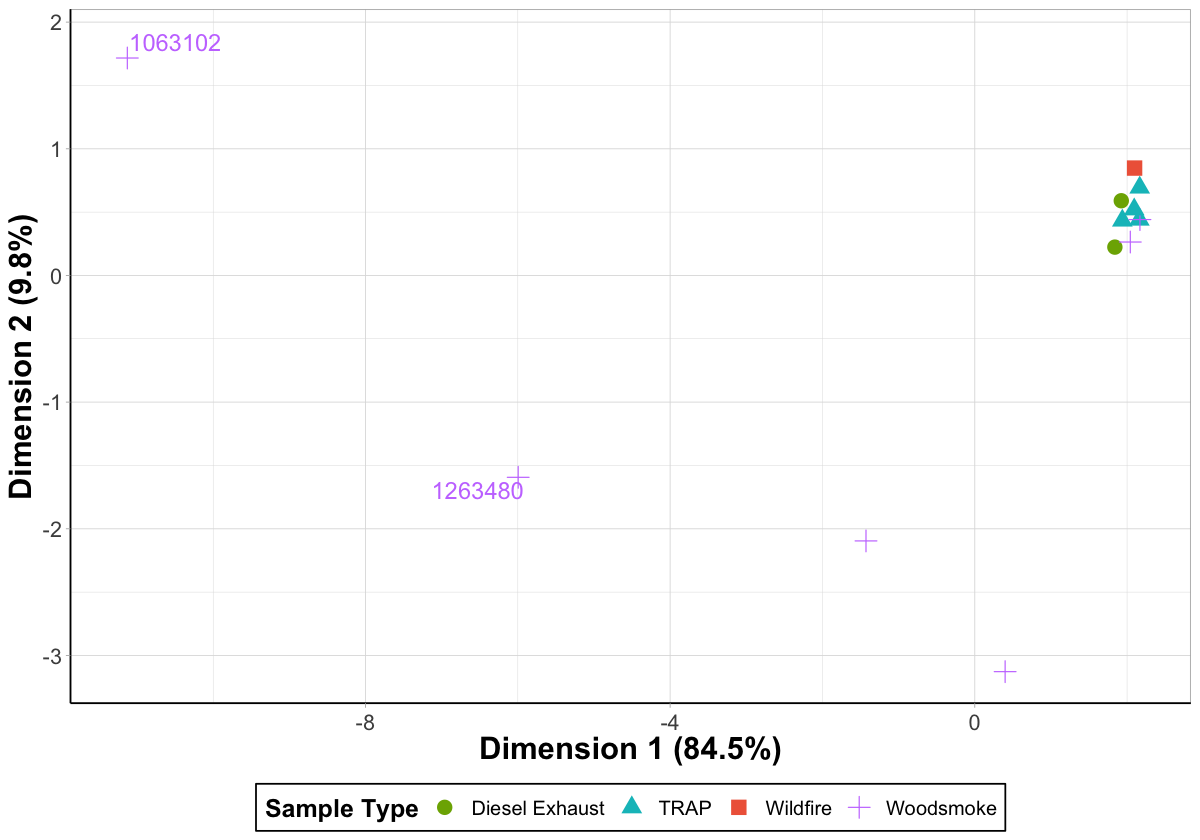

In [12]:
vol2 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'PAH'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'PAH', PC1 < -4), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5, show.legend = FALSE) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (84.5%)', y = 'Dimension 2 (9.8%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2:3], palette_colors[c(5)], cols[4])) 

vol2

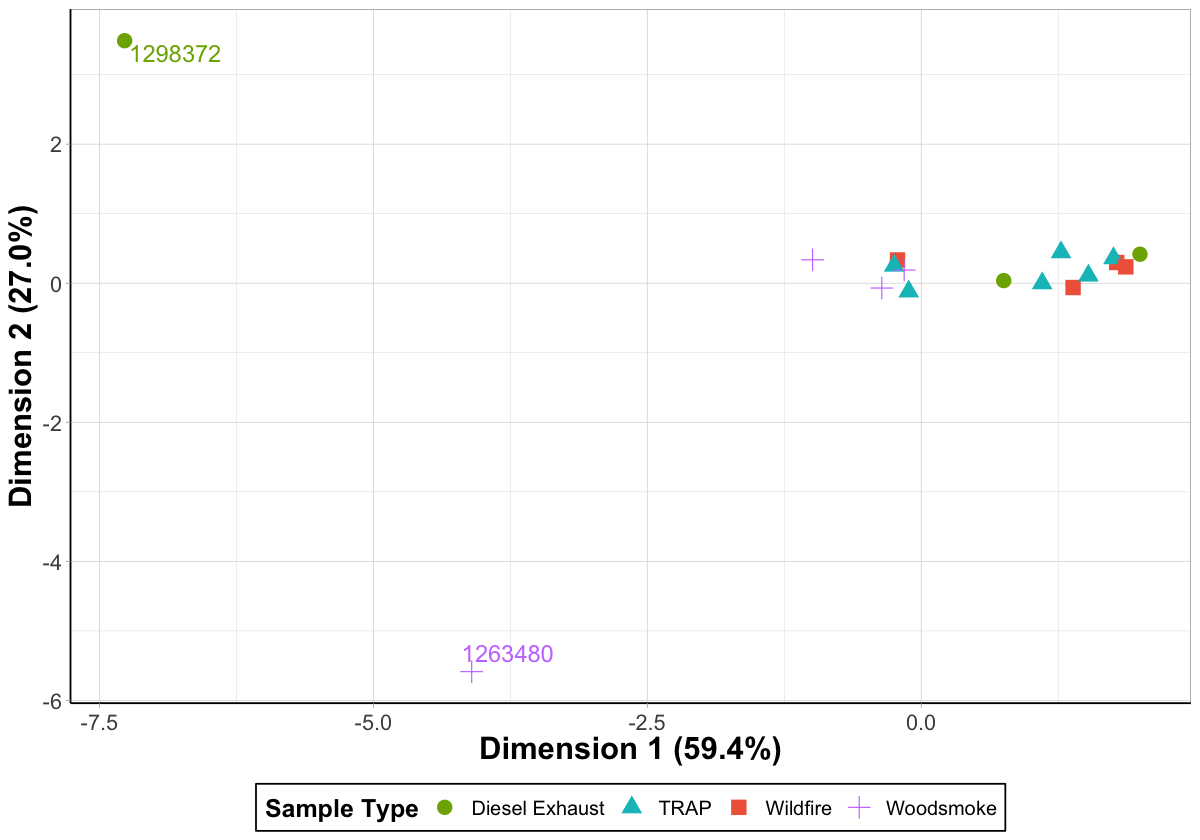

In [13]:
vol3 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'VOC'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4, position = position_jitter(w = 0.2, h = 0.2), alpha = 1) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Volume', Class == 'VOC', PC1 < -2.5), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5, show.legend = FALSE) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (59.4%)', y = 'Dimension 2 (27.0%)',
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(name = "Sample Type",
                      values = c(cols[2:3], palette_colors[c(5)], cols[4]))

vol3

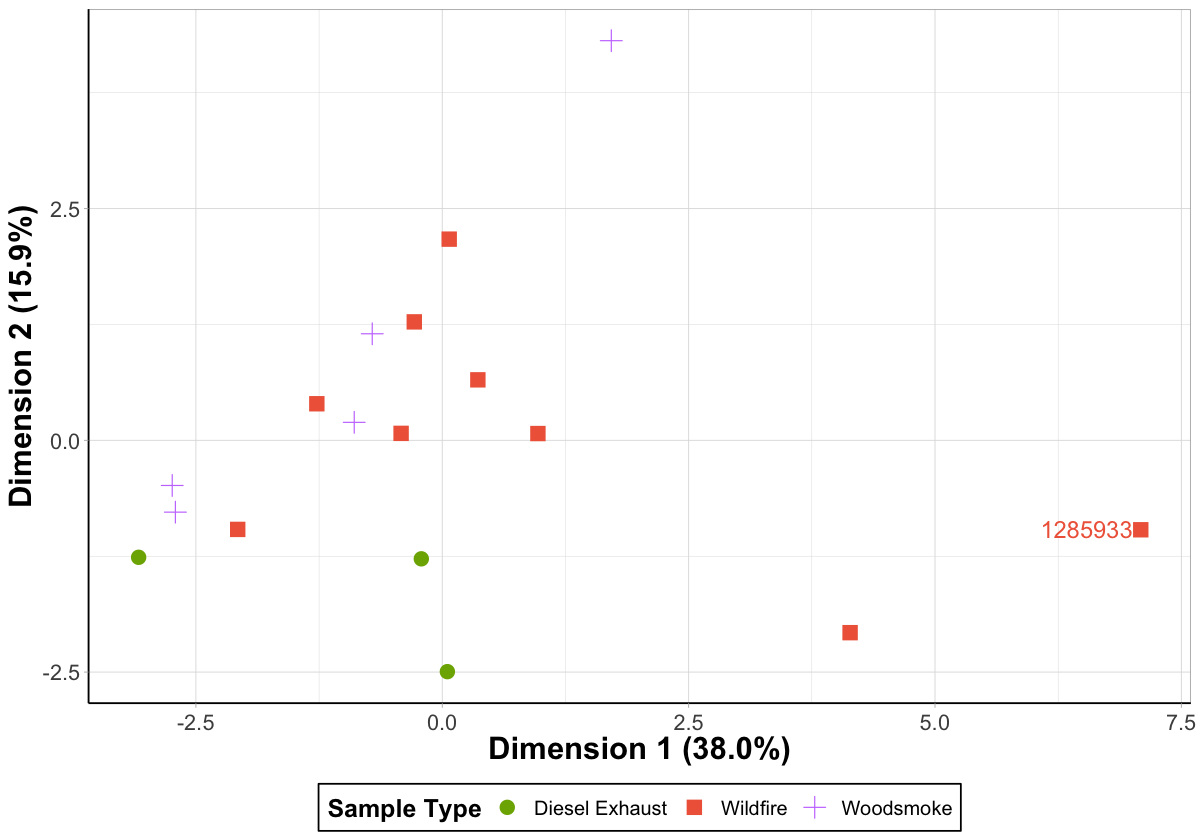

In [14]:
options(repr.plot.width=10, repr.plot.height=7) #changing size

weight1 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', Class == 'Metal'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4) + 
  geom_text_repel(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', Class == 'Metal', PC1 > 5), 
                  aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5, show.legend = FALSE) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (38.0%)', y = 'Dimension 2 (15.9%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2], palette_colors[c(5)], cols[4])) +
  scale_shape_manual(name = "Sample Type",
                     values = c(16,15,3))

weight1

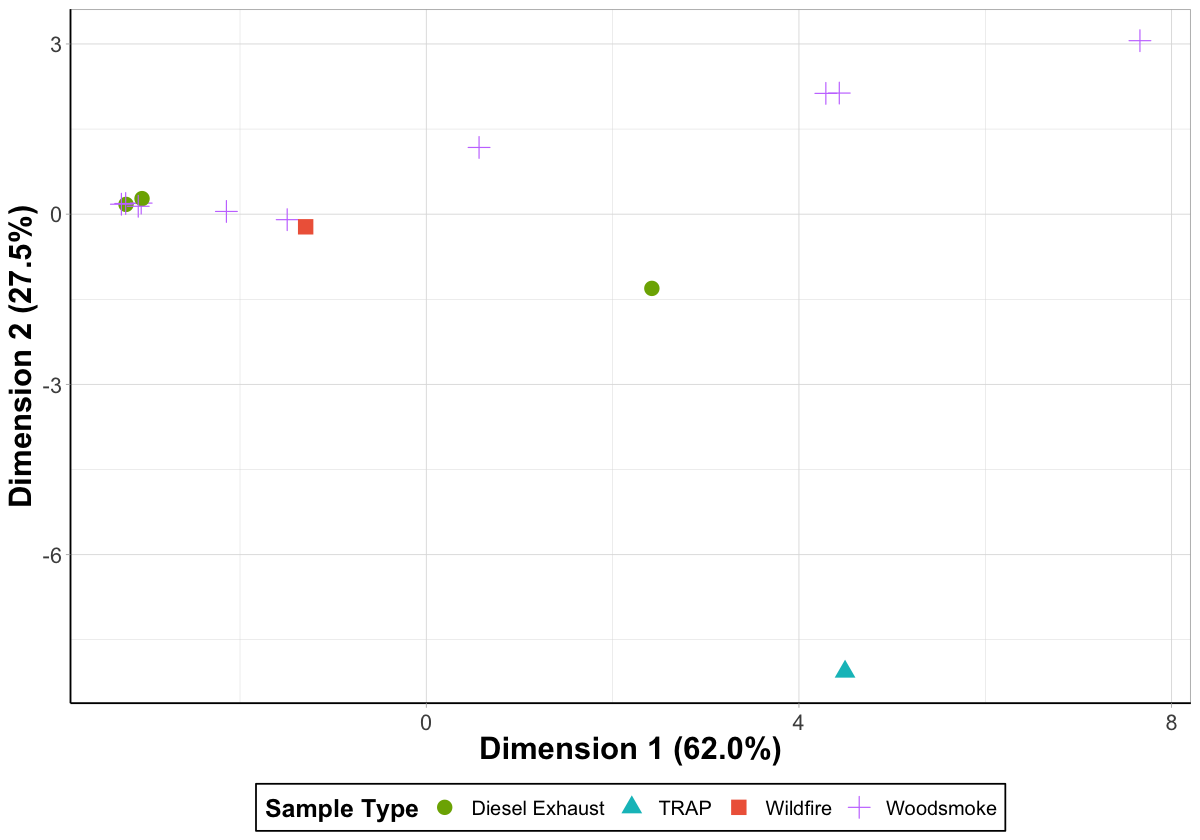

In [15]:
weight2 = ggplot(data = full_eigenvector_df %>%
           filter(Metric == 'Weight', Class == 'PAH'), 
       aes(x = PC1, y = PC2, color = Data, shape = Data)) + 
  geom_point(size = 4) + 
  # geom_text_repel(data = full_eigenvector_df %>%
  #          filter(Metric == 'Weight', Class == 'PAH', PC1 > 5), 
  #                 aes(x = PC1, y = PC2, color = Data, label = HAWC_ID), size = 5, show.legend = FALSE) +

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 15), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = "bottom", 
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 

  labs(x = 'Dimension 1 (62.0%)', y = 'Dimension 2 (27.5%)', #changing axis labels 
       color = "Sample Type", shape = "Sample Type") + #changing legend title

  scale_color_manual(values = c(cols[2:3], palette_colors[c(5)], cols[4]))

weight2

## Top Metal or Chemical Contributors to PCA

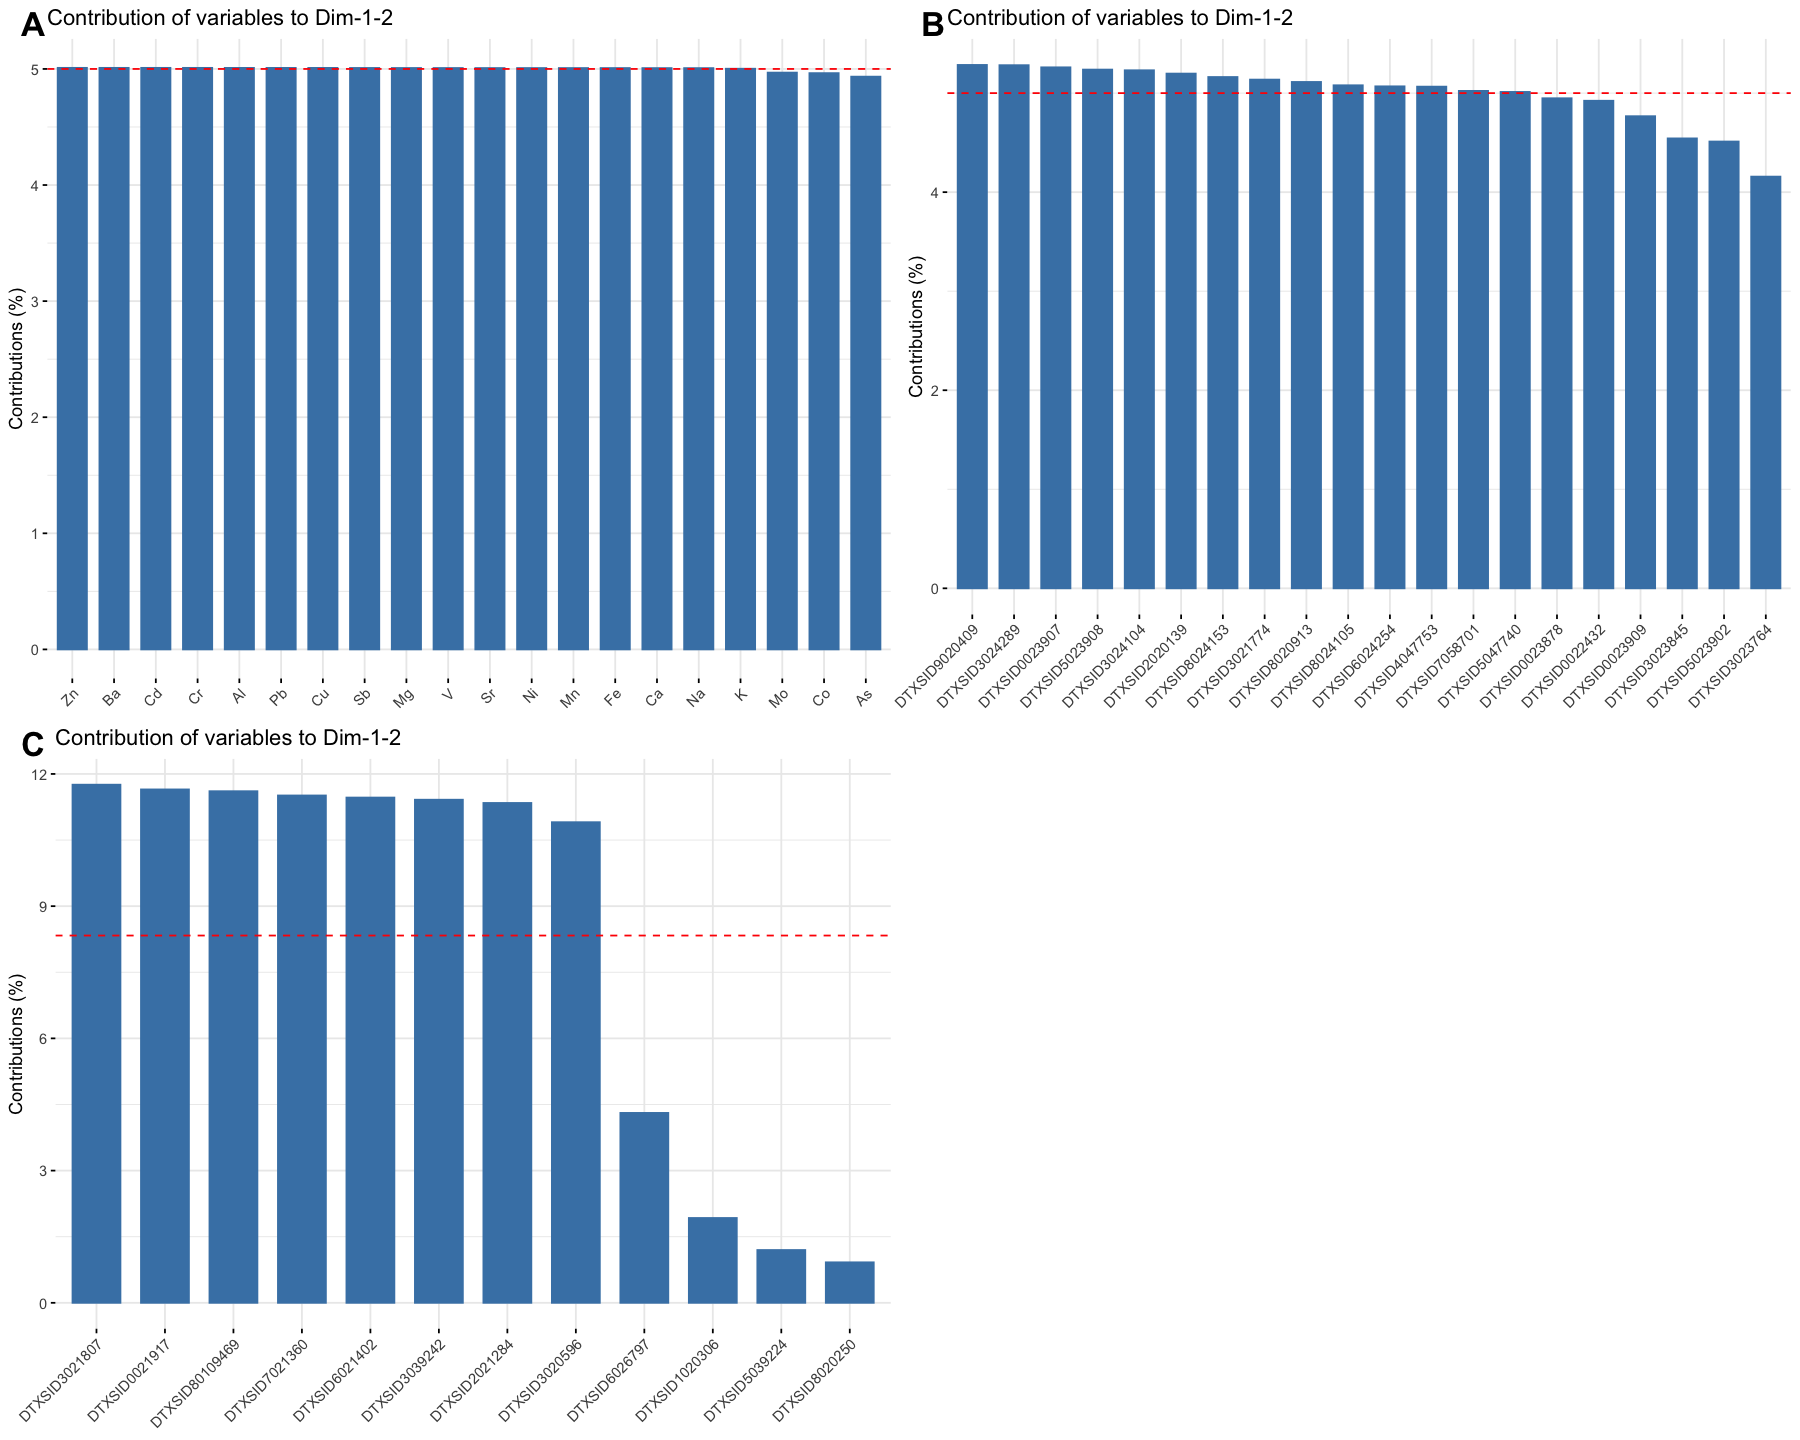

In [16]:
options(repr.plot.width=15, repr.plot.height=12) #changing size
# total contribution on PC1 and PC2
metal_vol_var = fviz_contrib(metal_vol_pca, choice = "var", axes = 1:2)
pah_vol_var = fviz_contrib(pah_vol_pca, choice = "var", axes = 1:2)
voc_vol_var = fviz_contrib(voc_vol_pca, choice = "var", axes = 1:2)

# combining
vol_var_contrib = plot_grid(metal_vol_var, pah_vol_var, voc_vol_var, nrow = 2,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.01, label_y = 1)
vol_var_contrib

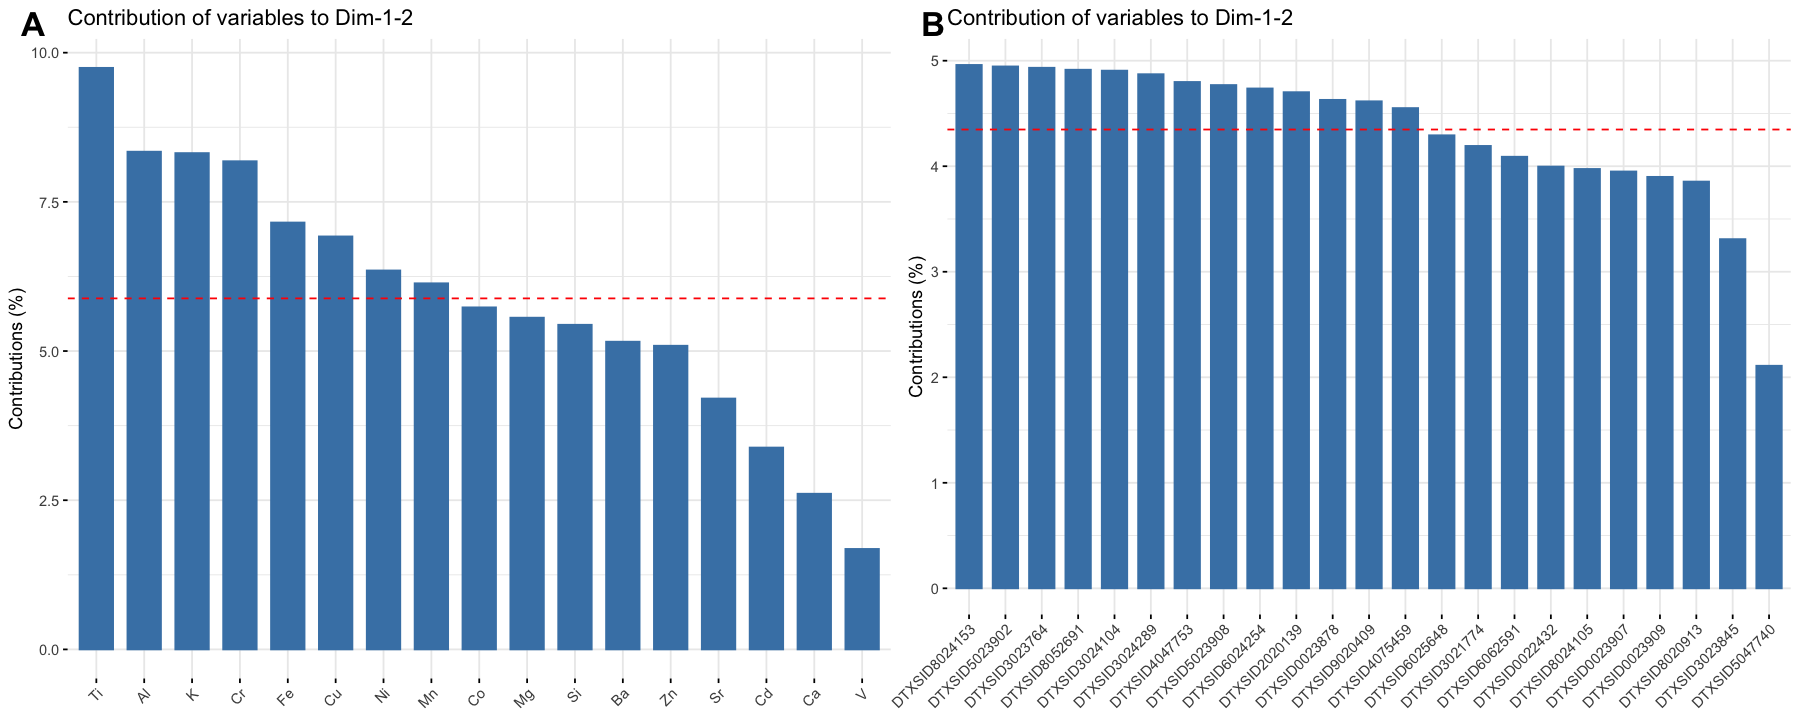

In [17]:
options(repr.plot.width=15, repr.plot.height=6) #changing size
metal_weight_var = fviz_contrib(metal_weight_pca, choice = "var", axes = 1:2)
pah_weight_var = fviz_contrib(pah_weight_pca, choice = "var", axes = 1:2)

# combining
weight_var_contrib = plot_grid(metal_weight_var, pah_weight_var, nrow = 1,
                            # adding labels, changing size their size and position
                            labels = "AUTO", label_size = 20, label_x = 0.01, label_y = 1)
weight_var_contrib

# Heatmaps

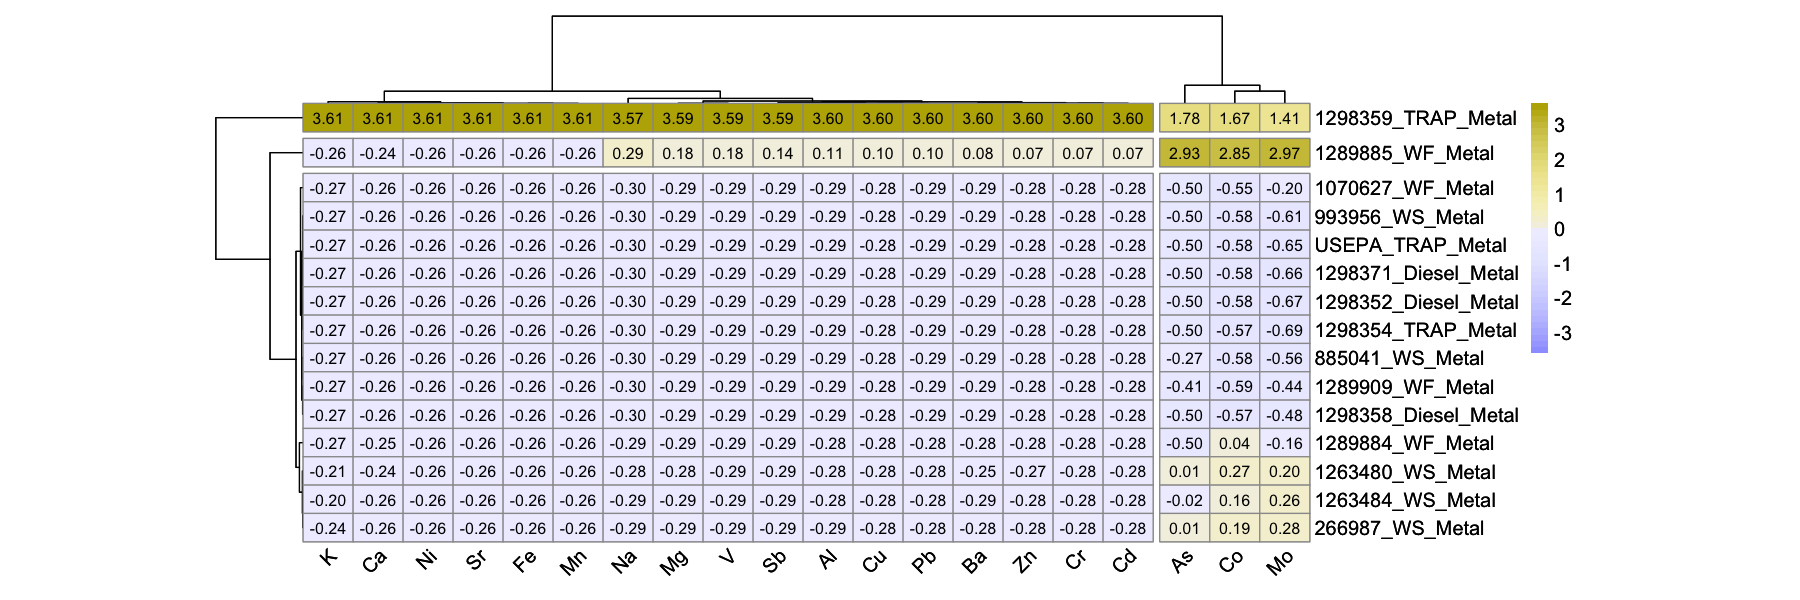

In [18]:
options(repr.plot.width=15, repr.plot.height=5) #changing size
vol_map1 = pheatmap(wider_metal_vol_df[,6:ncol(wider_metal_vol_df)], cluster_rows = TRUE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12, scale = 'column',
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Yellow 3"),
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3, cutree_col = 2) # adds a break bewtween the largest clusters

vol_map1

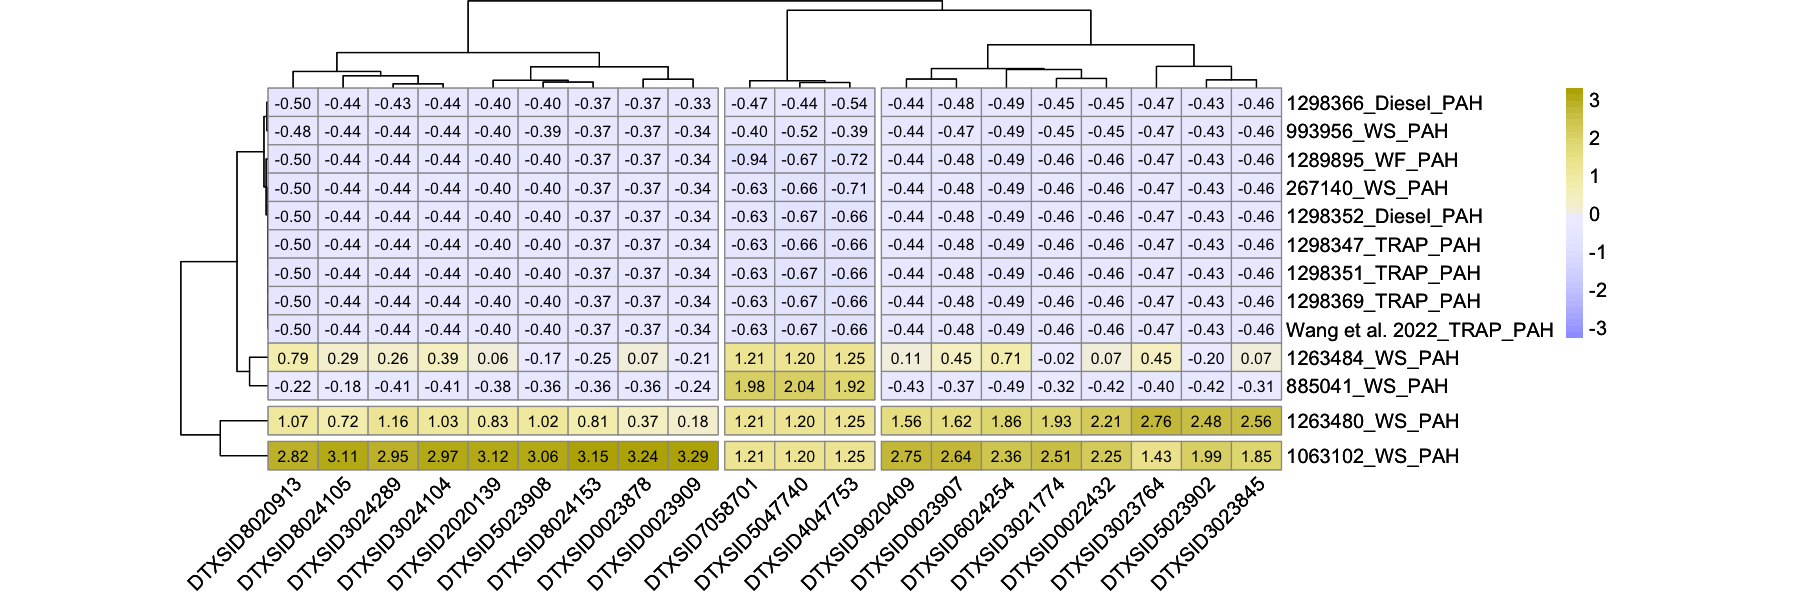

In [19]:
vol_map2 = pheatmap(wider_pah_vol_df[,6:ncol(wider_pah_vol_df)], cluster_rows = TRUE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12, scale = 'column',
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Yellow 3"),
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3, cutree_col = 3) # adds a break bewtween the largest clusters

vol_map2

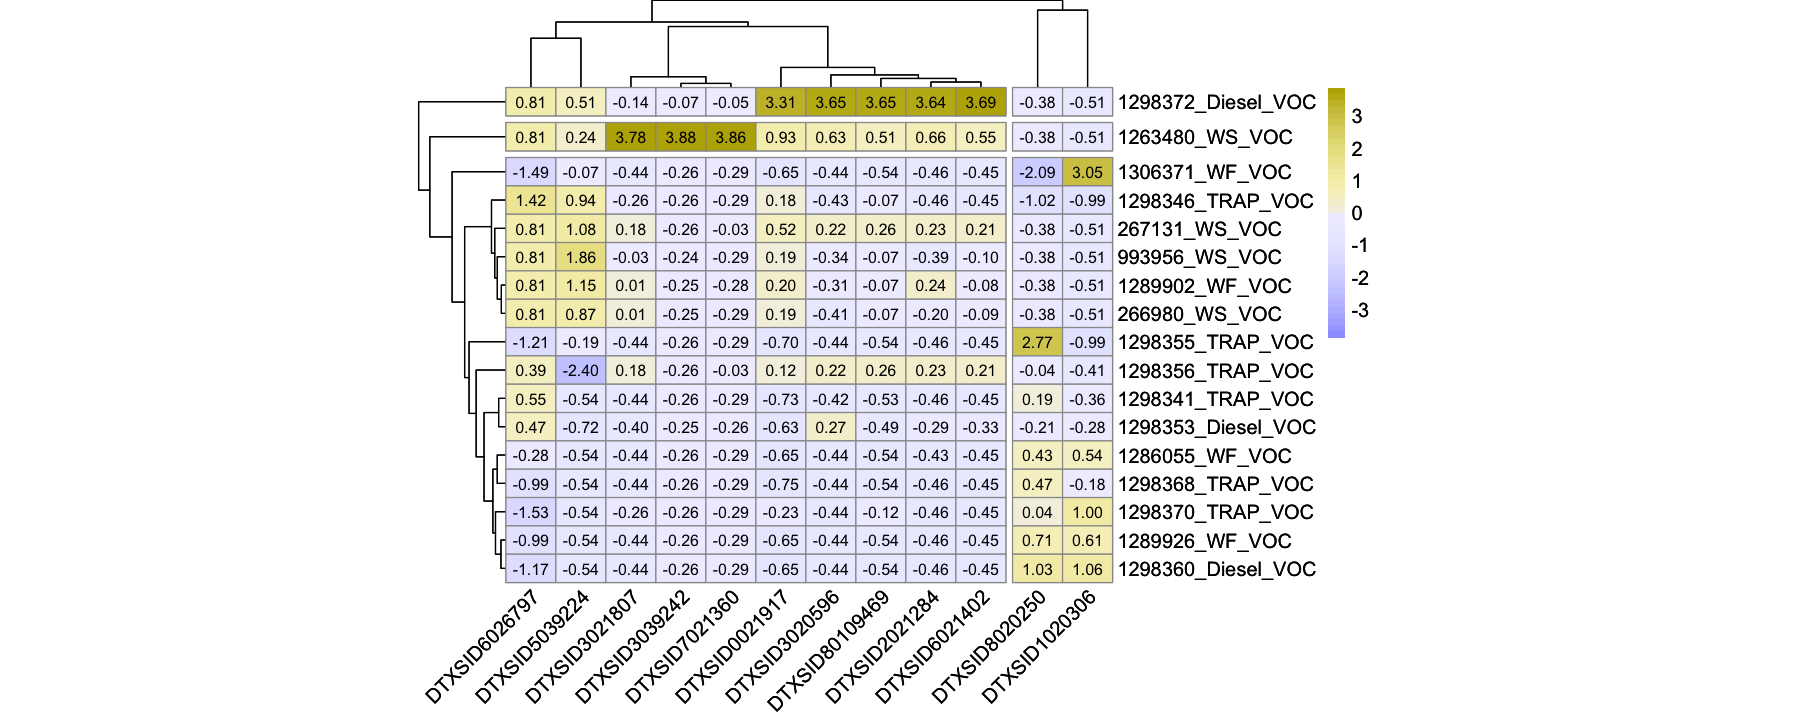

In [20]:
options(repr.plot.width=15, repr.plot.height=6) #changing size
vol_map3 = pheatmap(wider_voc_vol_df[,6:ncol(wider_voc_vol_df)], cluster_rows = TRUE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12, scale = 'column',
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Yellow 3"),
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3, cutree_col = 2) # adds a break bewtween the largest clusters

vol_map3

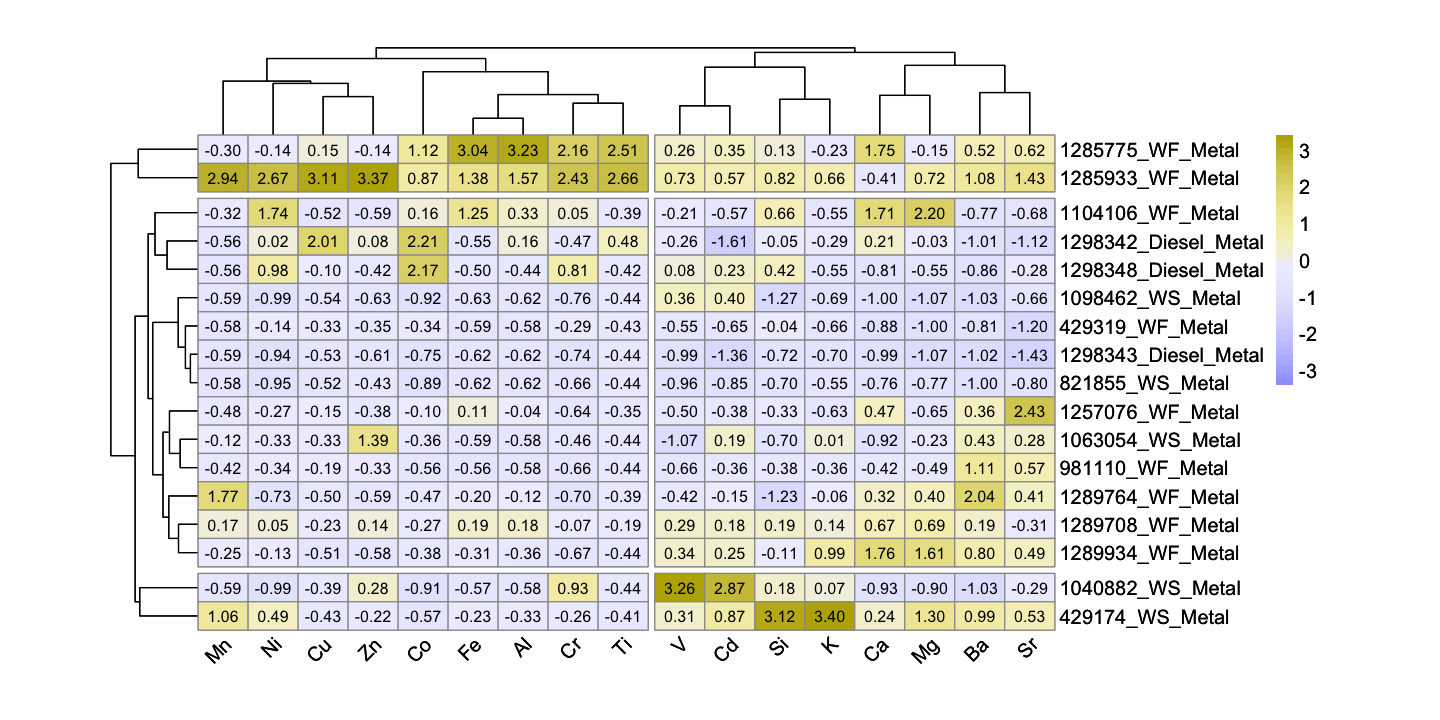

In [21]:
options(repr.plot.width=12, repr.plot.height=6) #changing size
weight_map1 = pheatmap(wider_metal_weight_df[,6:ncol(wider_metal_weight_df)], cluster_rows = TRUE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12, scale = 'column',
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Yellow 3"),
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3, cutree_col = 2) # adds a break bewtween the largest clusters

weight_map1

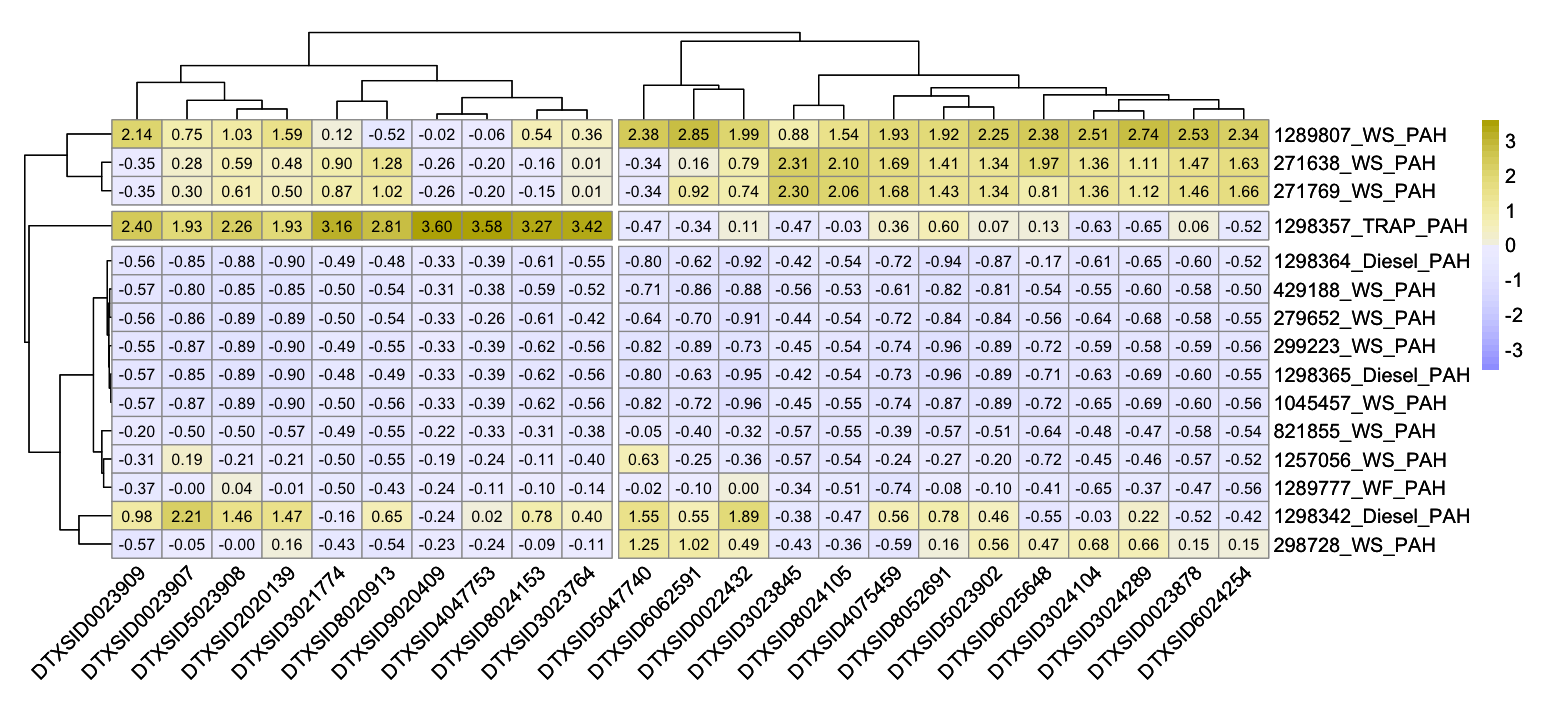

In [22]:
options(repr.plot.width=13, repr.plot.height=6) #changing size
weight_map2 = pheatmap(wider_pah_weight_df[,6:ncol(wider_pah_weight_df)], cluster_rows = TRUE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12, scale = 'column',
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Yellow 3"),
         display_numbers = TRUE, number_color = "black", 
         cutree_row = 3, cutree_col = 2) # adds a break bewtween the largest clusters

weight_map2

# PCA & Heatmaps

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

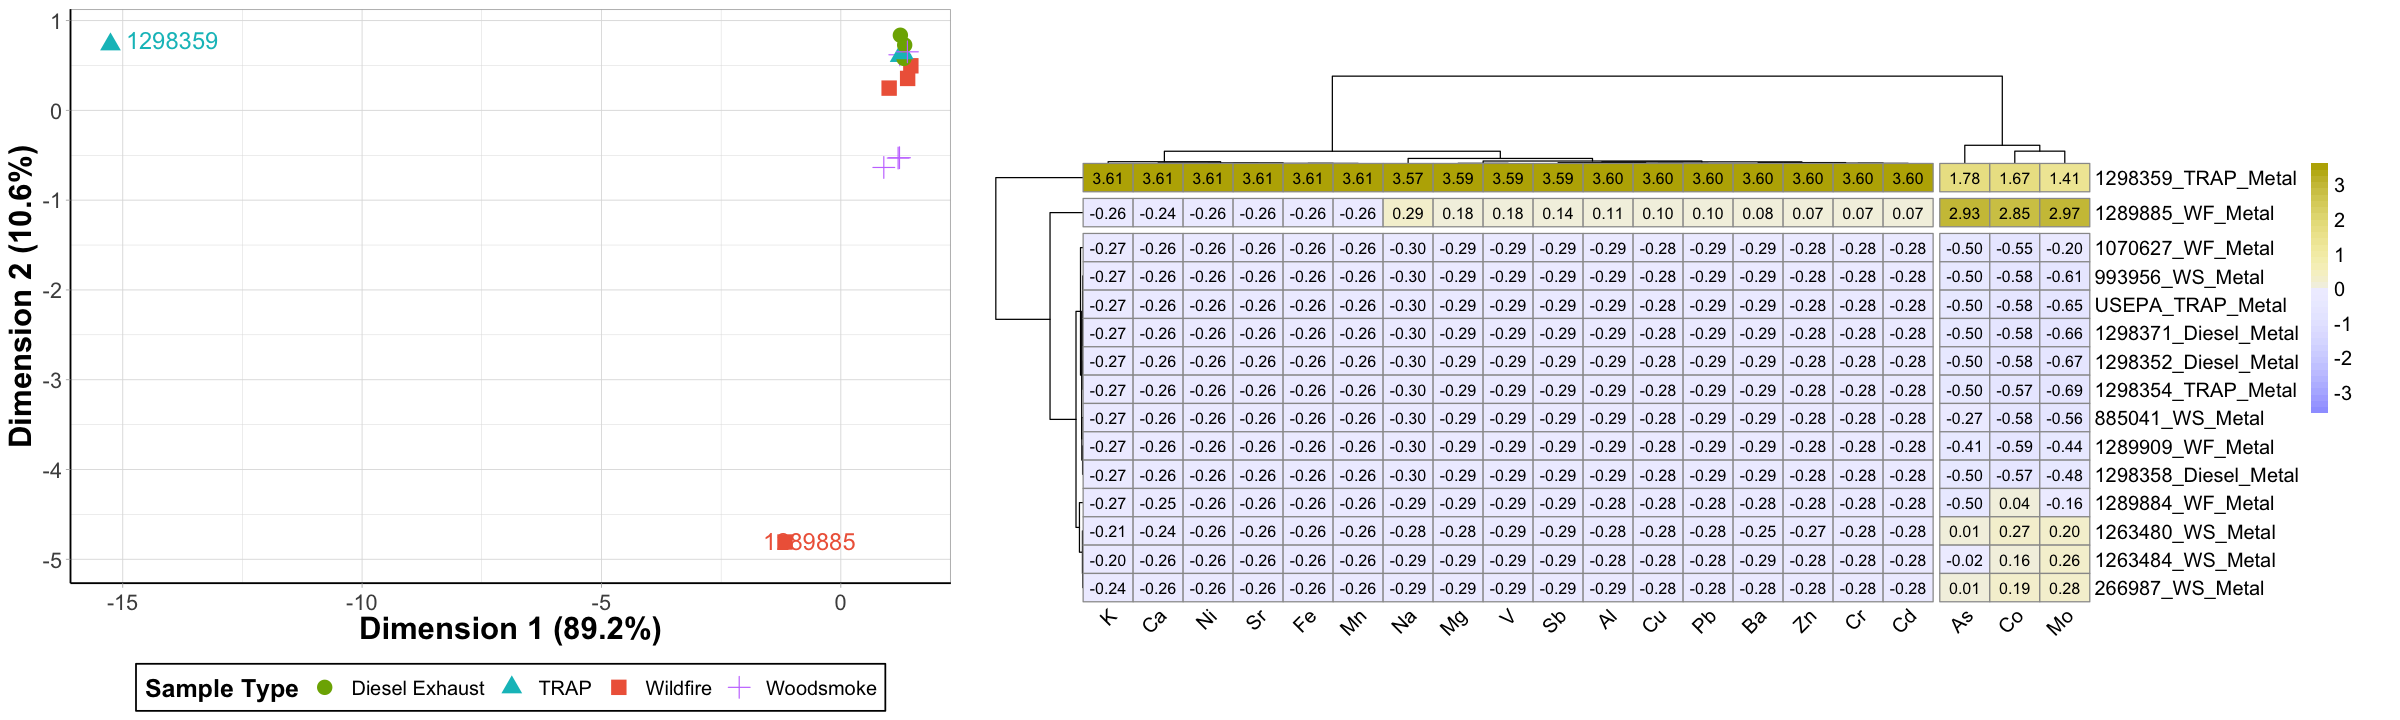

In [23]:
options(repr.plot.width=20, repr.plot.height=6) #changing size
# creating 1 figure
metal_vol_fig = grid.arrange(vol1, vol_map1[[4]],  widths = c(0.4, 0.6), ncol = 2)
metal_vol_fig

TableGrob (1 x 2) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]

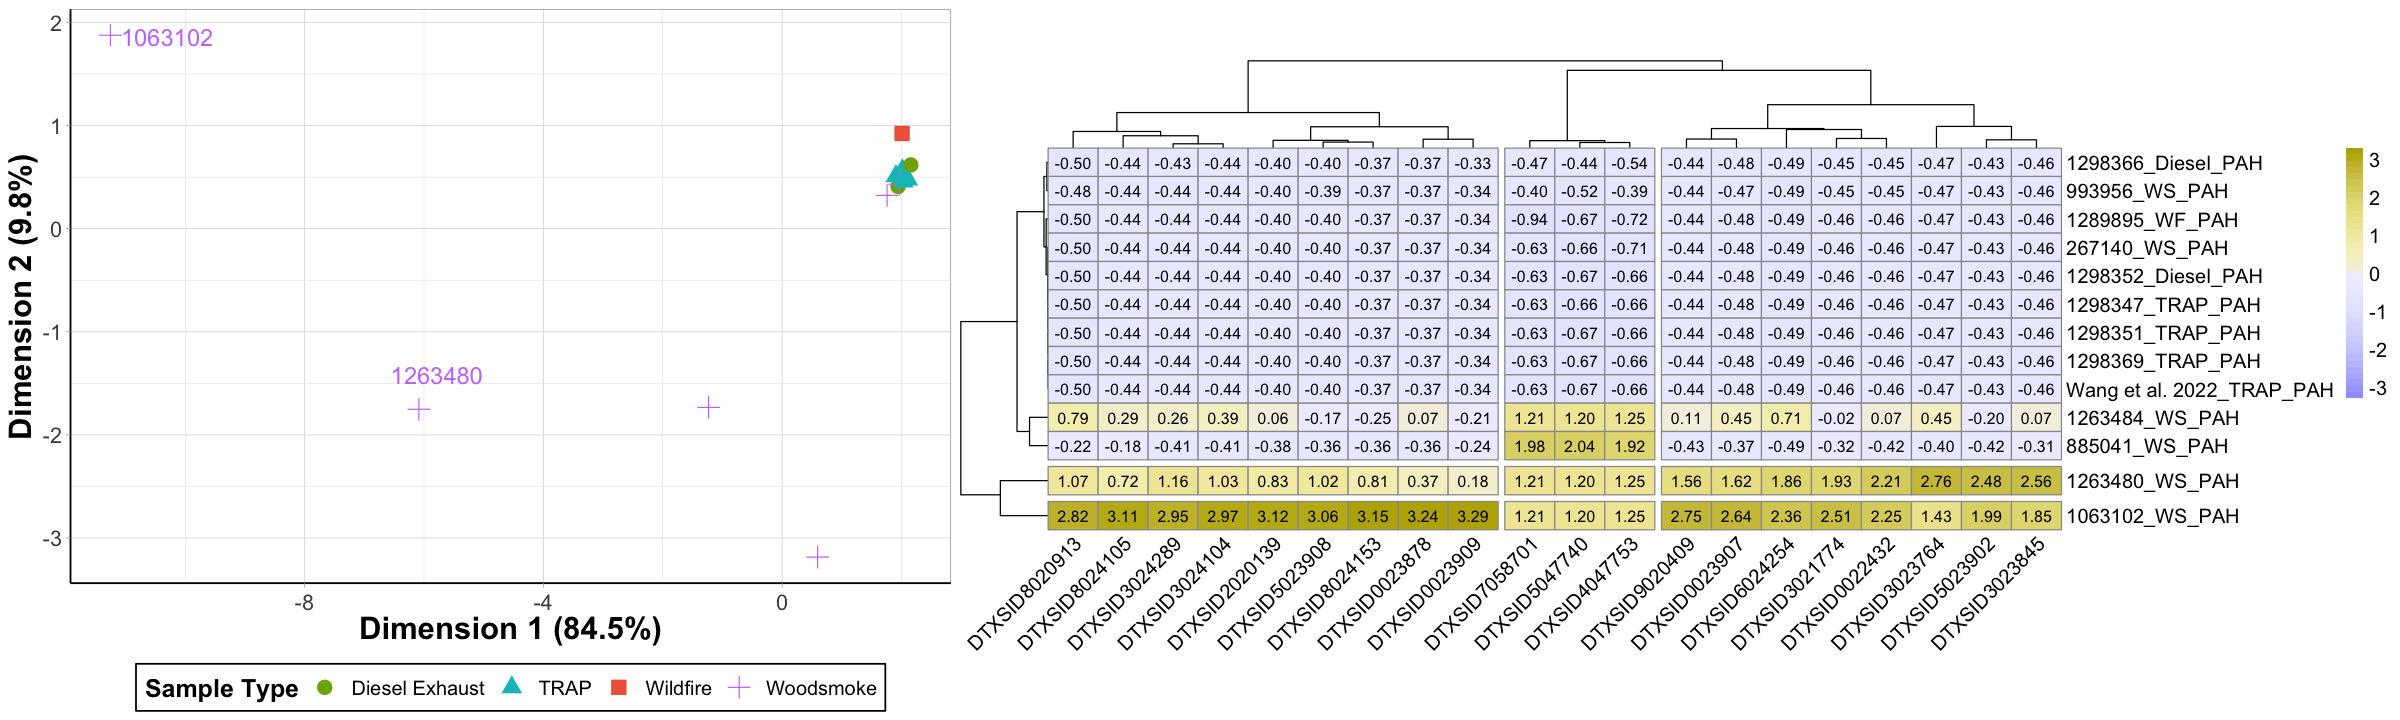

In [24]:
pah_vol_fig = grid.arrange(vol2, vol_map2[[4]],  widths = c(0.4, 0.6), ncol = 2)
pah_vol_fig